In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
device = torch.device('cuda') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cpu')

In [4]:
complete = pd.read_csv('EOF.csv')
# data is cut off because collab didnt finish loading the entire csv
# which is why we have < 1.2 million rows here
complete

,folderidx,float,profileidx,year,month,day,lat,lon,nlat,nlon,...,ts4,ts5,ts6,ts7,ts8,ssh_slope,ssh_dir,bath_slope,bath_dir,roughness
0,0.0,1901932.0,0.0,2021.0,5.0,20.0,-39.7900,30.0635,-36.8170,30.9419,...,-1.469766,-0.750992,-0.662656,-0.047516,-0.002373,0.0,0.0,0.0,0.0,0.0
1,0.0,1901932.0,1.0,2021.0,5.0,30.0,-36.8170,30.9419,-38.4510,32.7565,...,-4.411510,0.422385,-0.068476,-0.906169,-0.072356,0.0,0.0,0.0,0.0,0.0
2,0.0,1901932.0,2.0,2021.0,6.0,9.0,-38.4510,32.7565,-40.0302,35.9652,...,-0.668177,-0.787948,-0.472165,0.048625,0.050058,0.0,0.0,0.0,0.0,0.0
3,0.0,1901932.0,3.0,2021.0,6.0,19.0,-40.0302,35.9652,-39.2969,38.6928,...,-1.104086,-0.824606,-0.262984,0.291729,-0.280132,0.0,0.0,0.0,0.0,0.0
4,0.0,1901932.0,4.0,2021.0,6.0,29.0,-39.2969,38.6928,-38.0227,40.9031,...,-0.764814,-0.671834,-0.252487,0.113580,0.043449,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1901270.0,21.0,2012.0,6.0,1.0,-34.3920,-37.3270,-34.3820,-36.9020,...,0.760080,-1.756200,0.753141,0.250715,-0.503962,0.0,0.0,0.0,0.0,0.0
9996,0.0,1901270.0,22.0,2012.0,6.0,11.0,-34.3820,-36.9020,-34.5850,-36.5780,...,0.835049,-1.793005,0.575829,0.513536,-0.646926,0.0,0.0,0.0,0.0,0.0
9997,0.0,1901270.0,23.0,2012.0,6.0,21.0,-34.5850,-36.5780,-34.8270,-36.3610,...,0.668552,-1.798424,0.491682,0.455798,-0.679127,0.0,0.0,0.0,0.0,0.0
9998,0.0,1901270.0,25.0,2012.0,7.0,11.0,-35.0180,-36.1510,-35.1650,-36.0260,...,-0.052515,-1.764118,0.082194,0.490427,-1.009203,0.0,0.0,0.0,0.0,0.0


In [5]:
data = complete.assign(dy=complete.get('nlat')-complete.get('lat'));
data = data.assign(dx=data.get('nlon')-data.get('lon'));
for i in range(1, 9):
  data[f'prev_ts{i}'] = data[f'ts{i}'].shift(1)
data['prev_dy'] = data['dy'].shift(1)
data['prev_dx'] = data['dx'].shift(1)

mask = (data['folderidx'] == data['folderidx'].shift(1)) & \
       (data['float'] == data['float'].shift(1)) & \
       (data['profileidx'] == data['profileidx'].shift(1) + 1)
data.loc[~mask, [f'prev_ts{i}' for i in range(1, 9)]] = np.nan
data = data.dropna()
data

,folderidx,float,profileidx,year,month,day,lat,lon,nlat,nlon,...,prev_ts1,prev_ts2,prev_ts3,prev_ts4,prev_ts5,prev_ts6,prev_ts7,prev_ts8,prev_dy,prev_dx
1,0.0,1901932.0,1.0,2021.0,5.0,30.0,-36.8170,30.9419,-38.4510,32.7565,...,-8.429544,-2.753714,-2.788564,-1.469766,-0.750992,-0.662656,-0.047516,-0.002373,2.9730,0.8784
2,0.0,1901932.0,2.0,2021.0,6.0,9.0,-38.4510,32.7565,-40.0302,35.9652,...,-16.224981,-2.328750,-2.156176,-4.411510,0.422385,-0.068476,-0.906169,-0.072356,-1.6340,1.8146
3,0.0,1901932.0,3.0,2021.0,6.0,19.0,-40.0302,35.9652,-39.2969,38.6928,...,-4.645711,-3.005418,-1.453715,-0.668177,-0.787948,-0.472165,0.048625,0.050058,-1.5792,3.2087
4,0.0,1901932.0,4.0,2021.0,6.0,29.0,-39.2969,38.6928,-38.0227,40.9031,...,-7.028408,-3.373396,-2.194893,-1.104086,-0.824606,-0.262984,0.291729,-0.280132,0.7333,2.7276
5,0.0,1901932.0,5.0,2021.0,7.0,8.0,-38.0227,40.9031,-40.4052,43.1839,...,-3.312371,-3.200434,-1.266698,-0.764814,-0.671834,-0.252487,0.113580,0.043449,1.2742,2.2103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0,1901270.0,20.0,2012.0,5.0,22.0,-34.6030,-37.7250,-34.3920,-37.3270,...,-3.817698,-4.599620,-5.528163,0.528060,-1.712870,1.115541,0.310922,-0.593749,0.4810,0.0410
9995,0.0,1901270.0,21.0,2012.0,6.0,1.0,-34.3920,-37.3270,-34.3820,-36.9020,...,-2.815671,-4.453010,-4.868307,0.697028,-1.711296,0.876660,0.124823,-0.264297,0.2110,0.3980
9996,0.0,1901270.0,22.0,2012.0,6.0,11.0,-34.3820,-36.9020,-34.5850,-36.5780,...,-3.701556,-4.312377,-5.325528,0.760080,-1.756200,0.753141,0.250715,-0.503962,0.0100,0.4250
9997,0.0,1901270.0,23.0,2012.0,6.0,21.0,-34.5850,-36.5780,-34.8270,-36.3610,...,-5.364796,-4.041777,-6.015128,0.835049,-1.793005,0.575829,0.513536,-0.646926,-0.2030,0.3240


In [ ]:
# data = data.assign(magnitude=np.sqrt(data.get('dy')**2 + data.get('dx')**2))
# data = data.assign(angle=np.arctan2(data.get('dy'), data.get('dx')))
final = data[['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8',
             'prev_ts1', 'prev_ts2', 'prev_ts3', 'prev_ts4', 'prev_ts5', 'prev_ts6',
             'prev_ts7', 'prev_ts8', 'prev_dy', 'prev_dx', 'dy', 'dx']].dropna()
# final = data[['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8', 'prev_dy', 'prev_dx', 'dy', 'dx']].dropna()
# final = data[['prev_dy', 'prev_dx', 'dy', 'dx']].dropna()
final

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,prev_ts1,prev_ts2,prev_ts3,prev_ts4,prev_ts5,prev_ts6,prev_ts7,prev_ts8,prev_dy,prev_dx,dy,dx
1,-16.224981,-2.328750,-2.156176,-4.411510,0.422385,-0.068476,-0.906169,-0.072356,-8.429544,-2.753714,-2.788564,-1.469766,-0.750992,-0.662656,-0.047516,-0.002373,2.973000,0.878400,-1.634000,1.814600
2,-4.645711,-3.005418,-1.453715,-0.668177,-0.787948,-0.472165,0.048625,0.050058,-16.224981,-2.328750,-2.156176,-4.411510,0.422385,-0.068476,-0.906169,-0.072356,-1.634000,1.814600,-1.579200,3.208700
3,-7.028408,-3.373396,-2.194893,-1.104086,-0.824606,-0.262984,0.291729,-0.280132,-4.645711,-3.005418,-1.453715,-0.668177,-0.787948,-0.472165,0.048625,0.050058,-1.579200,3.208700,0.733300,2.727600
4,-3.312371,-3.200434,-1.266698,-0.764814,-0.671834,-0.252487,0.113580,0.043449,-7.028408,-3.373396,-2.194893,-1.104086,-0.824606,-0.262984,0.291729,-0.280132,0.733300,2.727600,1.274200,2.210300
5,-6.705677,-3.362632,-2.880280,-0.932893,-0.754205,-0.101104,0.229183,-0.117152,-3.312371,-3.200434,-1.266698,-0.764814,-0.671834,-0.252487,0.113580,0.043449,1.274200,2.210300,-2.382500,2.280800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672536,12.644987,8.405363,-3.166004,-0.312431,0.789002,0.049204,-0.009593,0.215021,12.979702,8.439695,-3.038574,-0.342376,0.732749,-0.002921,0.079163,0.109564,0.134003,0.826000,0.566998,-0.846001
672537,12.935516,8.311245,-2.942153,-0.279141,0.746629,0.077118,0.046376,0.147360,12.644987,8.405363,-3.166004,-0.312431,0.789002,0.049204,-0.009593,0.215021,0.566998,-0.846001,0.075001,-0.596001
672538,12.798977,8.284878,-2.869666,-0.397023,0.725886,-0.138351,0.133228,0.018803,12.935516,8.311245,-2.942153,-0.279141,0.746629,0.077118,0.046376,0.147360,0.075001,-0.596001,-0.610001,-0.306000
672539,12.433056,8.095170,-3.056265,-0.206220,0.801943,-0.045521,0.115224,0.066750,12.798977,8.284878,-2.869666,-0.397023,0.725886,-0.138351,0.133228,0.018803,-0.610001,-0.306000,0.451000,0.272001


In [ ]:
Y = final[['dy', 'dx']].to_numpy()
X = final.drop(columns=['dy', 'dx']).to_numpy()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)
r_squared = r2_score(Y, Y_pred)
R = np.sqrt(r_squared)

print("Coefficient of Multiple Correlation (R):", R)

X = torch.tensor(X).float().to(device)
Y = torch.tensor(Y).float().to(device)

# its 0.13 when not including prev profile
print('correlation btwn pred_dy and dy:', np.sqrt(r2_score(Y[:, 0], Y_pred[:, 0])))
print('correlation btwn pred_dx and dx:', np.sqrt(r2_score(Y[:, 1], Y_pred[:, 1])))

Coefficient of Multiple Correlation (R): 0.42334180174018926
correlation btwn pred_dy and dy: 0.295011591524155
correlation btwn pred_dx and dx: 0.5209651881625007


In [ ]:
# pretty much all weights are 0 except for the last (prev_dx)
model.coef_

array([[ 4.35578216e-03,  9.19802883e-03, -1.43749080e-02,
        -5.63130038e-03,  2.89507428e-02, -1.50477019e-03,
         1.36645651e-02,  1.68175992e-03, -4.30987135e-03,
        -9.21870928e-03,  1.37534476e-02,  4.81711730e-03,
        -2.75000856e-02,  6.98834505e-05, -1.28935208e-02,
        -1.28265499e-03,  2.95280420e-01,  7.03836236e-03],
       [ 9.13079113e-03, -8.91520012e-03, -2.68637006e-02,
         1.72395409e-02, -2.98964332e-04, -5.37650436e-02,
        -3.81803874e-03,  3.56936600e-02, -3.01142575e-03,
         1.32292153e-02,  3.01971691e-02, -2.42646187e-02,
        -1.09986852e-02,  3.49536474e-02,  1.73844074e-02,
        -3.92115939e-02, -5.41026912e-02,  4.94829365e-01]])

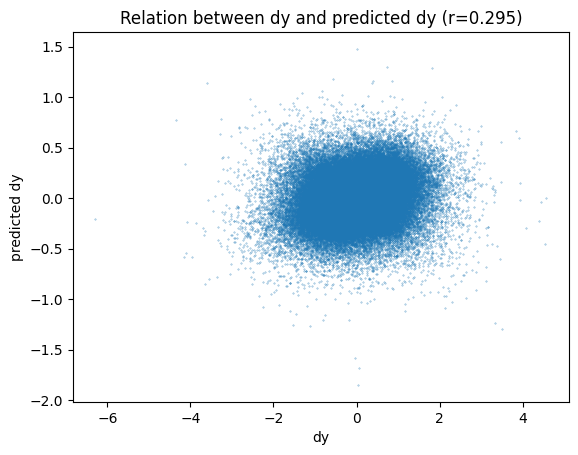

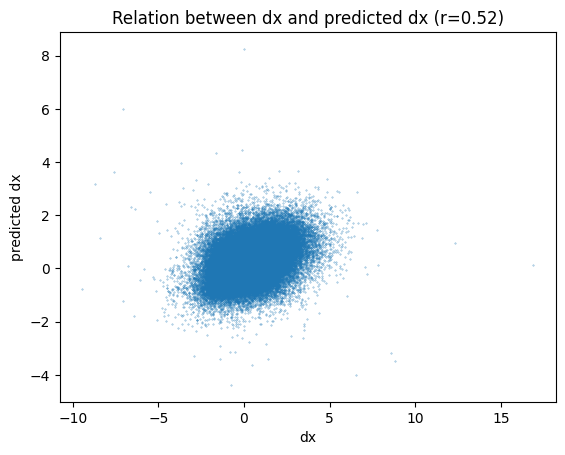

In [ ]:
# predictability of dx and dy
plt.scatter(Y[:, 0], Y_pred[:, 0], s=0.1, alpha=0.7);
plt.title('Relation between dy and predicted dy (r=0.295)')
plt.xlabel('dy')
plt.ylabel('predicted dy');
plt.show()

plt.scatter(Y[:, 1], Y_pred[:, 1], s=0.1, alpha=0.7);
plt.title('Relation between dx and predicted dx (r=0.52)')
plt.xlabel('dx')
plt.ylabel('predicted dx');
plt.show()

In [ ]:
# TODO: instead of doing a naive shuffle, keep profiles specific to floats (or regions) grouped together
X, Y = shuffle(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

training loss: 21.685387
test loss: 683.5501


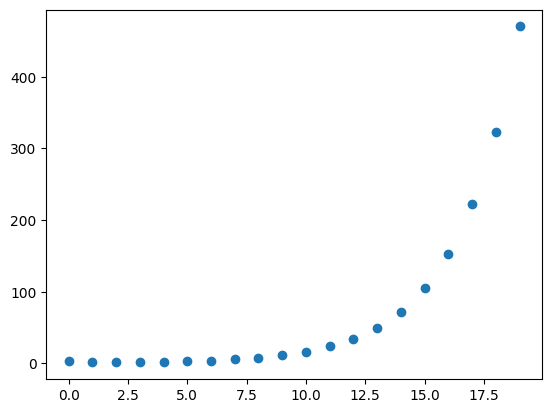

In [ ]:
model = nn.Sequential(
    nn.Linear(X.size()[1], 2)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(20):
  optimizer.zero_grad()

  guess = model(X_train)
  loss = criterion(guess, Y_train)
  loss.backward()
  optimizer.step()

  losses.append(loss.cpu().detach().numpy())

print("training loss:", np.sqrt(losses[-1]))
print("test loss:", criterion(model(X_test), Y_test).cpu().detach().numpy())
plt.scatter(np.arange(len(losses)), losses)

In [ ]:
# picking a contiguous sequence
just_one = data[data.get('float') == 5903581.0].head(6)
small_test = torch.tensor(just_one[['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8', 'prev_dy', 'prev_dx']].to_numpy()).float().to(device)
# small_test = torch.tensor(just_one[['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8',
#              'prev_ts1', 'prev_ts2', 'prev_ts3', 'prev_ts4', 'prev_ts5', 'prev_ts6',
#              'prev_ts7', 'prev_ts8', 'prev_dy', 'prev_dx']].to_numpy()).float().to(device)
# small_test = torch.tensor(just_one[['prev_dy', 'prev_dx']].to_numpy()).float().to(device)
pred = model(small_test).detach().numpy()
just_one = just_one.assign(pnlat = pred[:, 0] + just_one.get('lat'))
just_one = just_one.assign(pnlon = pred[:, 1] + just_one.get('lon')).reset_index()
just_one

,index,folderidx,float,profileidx,year,month,day,lat,lon,nlat,...,prev_ts3,prev_ts4,prev_ts5,prev_ts6,prev_ts7,prev_ts8,prev_dy,prev_dx,pnlat,pnlon
0,629024,6.0,5903581.0,1.0,2013.0,11.0,21.0,-32.045,-45.792,-30.739,...,-7.195631,0.087664,-2.211091,-0.580614,0.518850,-1.293023,0.905,-0.635,-32.695964,-46.198522
1,629025,6.0,5903581.0,2.0,2013.0,12.0,1.0,-30.739,-46.463,-30.839,...,-8.056765,-2.247225,-1.422109,-0.883117,-0.075921,-1.072912,1.306,-0.671,-31.325427,-47.070532
2,629026,6.0,5903581.0,3.0,2013.0,12.0,11.0,-30.839,-47.600,-30.793,...,-7.650231,-1.004874,-1.955411,-0.957763,-0.159207,-0.745878,-0.100,-1.137,-31.207513,-47.846260
3,629028,6.0,5903581.0,6.0,2014.0,1.0,11.0,-31.095,-48.860,-31.092,...,-5.935511,0.155577,-1.542267,-0.532555,-0.020968,-0.834839,-0.181,-1.412,-30.884472,-49.115094
4,629029,6.0,5903581.0,7.0,2014.0,1.0,21.0,-31.092,-48.466,-31.590,...,-3.931922,1.053851,-2.015542,-0.212721,-0.523518,-0.296322,0.003,0.394,-31.021445,-49.385673
5,629030,6.0,5903581.0,8.0,2014.0,1.0,31.0,-31.590,-48.475,-32.256,...,-3.655928,2.043102,-2.186110,0.006548,-0.531333,-0.163089,-0.498,-0.009,-31.566419,-49.229637


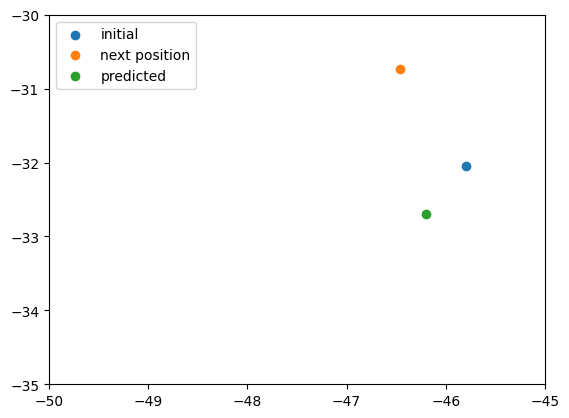

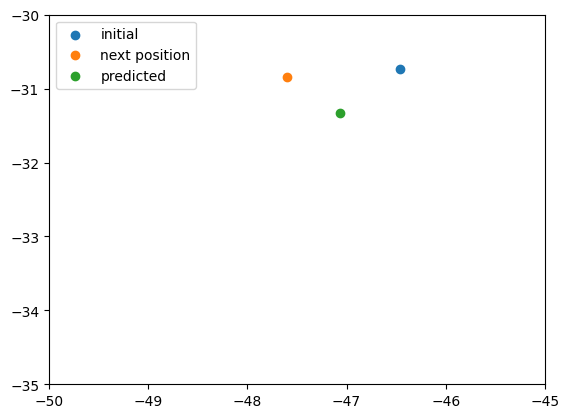

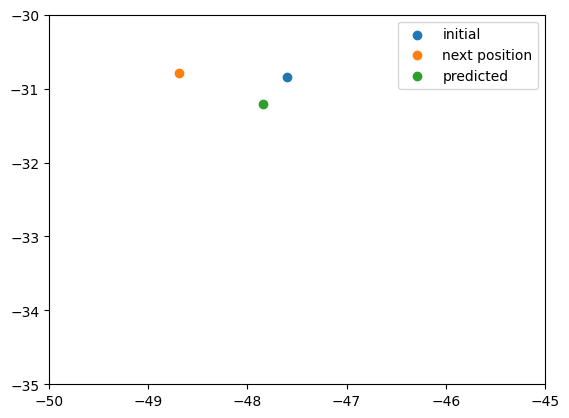

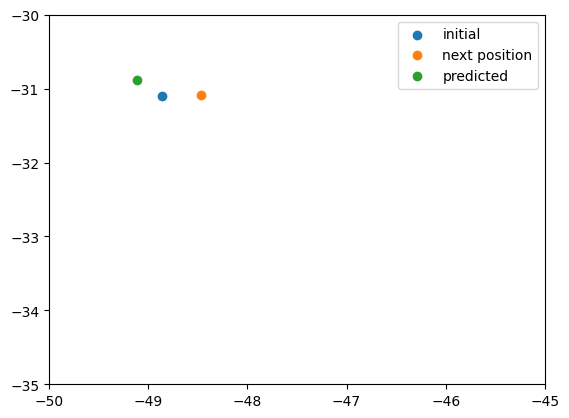

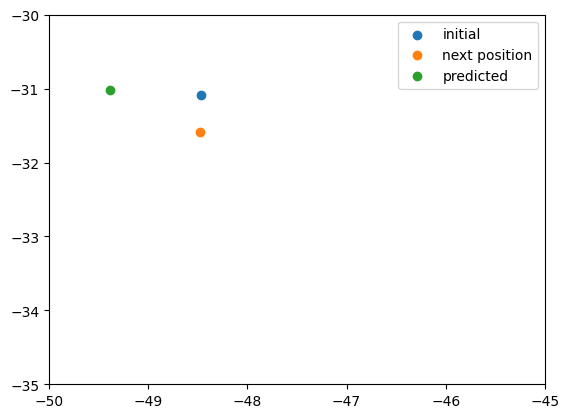

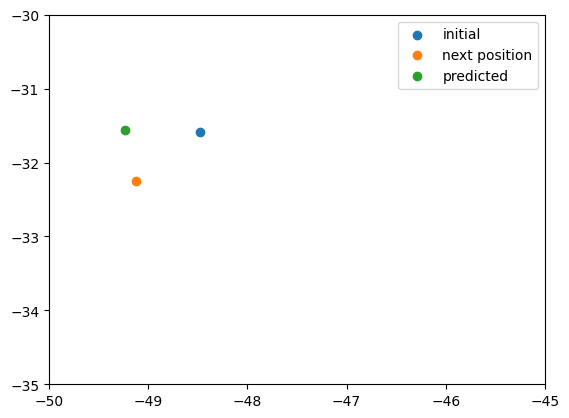

In [ ]:
for i in range(just_one.shape[0]):
  y_plot = [just_one.get('lat')[i], just_one.get('nlat')[i], just_one.get('pnlat')[i]]
  x_plot = [just_one.get('lon')[i], just_one.get('nlon')[i], just_one.get('pnlon')[i]]
  for j in range(3):
    plt.scatter(x_plot[j], y_plot[j])
  plt.legend(['initial', 'next position', 'predicted'])
  plt.xlim((-50, -45))
  plt.ylim((-35, -30))
  plt.show()